In [1]:
 %run /Desktop/Share/CUDA_DEVICE_setup.py -n 1

using GPU ID:3,



In [2]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

In [3]:
#%config Completer.use_jedi = False

import sys
sys.path.append('..')


from pprint import pprint    
import tensorflow as tf    
from collections import defaultdict
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from tndm.data import DataManager
from tndm import LFADS
from tndm.runtime import Runtime
from typing import Dict, Any
from sklearn.linear_model import Ridge

from plotting import *

In [4]:
# read the data/disk/scratch/cole/Chewie_CO_FF_2016-10-07_pos_M1_spikes/test_data/
spike_data_dir = "Chewie_CO_FF_2016-10-07_pos_M1_spikes/"

data_dir = os.path.join( spike_data_dir )

dataset, settings = DataManager.load_dataset(
    directory=data_dir,
    filename='dataset.h5')

#train
neural_data = dataset['train_data'].astype('float')
behavioural_data = dataset['train_behaviours'].astype('float')

# valid
valid_neural_data = dataset['valid_data'].astype('float')
valid_behavioural_data = dataset['valid_behaviours'].astype('float')

# test
test_neural_data = dataset['test_data'].astype('float')
test_behavioural_data = dataset['test_behaviours'].astype('float')

In [5]:
# center behaviour at zero, using first time step (not strictly required)
b_mean = np.mean(np.vstack((behavioural_data, test_behavioural_data, valid_behavioural_data))[:,0,:],axis=0)
for i in range(2):
    behavioural_data[:,:,i] = behavioural_data[:,:,i]-b_mean[i]
    valid_behavioural_data[:,:,i] = valid_behavioural_data[:,:,i]-b_mean[i]
    test_behavioural_data[:,:,i] = test_behavioural_data[:,:,i]-b_mean[i]

# get dataset, to train by myself
# with_behaviour = False for lfads
# target = input for reconstruction

In [6]:
(x_train, y_train), (x_val, y_val) = Runtime.clean_datasets(
            train_dataset=(neural_data, behavioural_data), 
            val_dataset=(valid_neural_data, valid_behavioural_data), 
            with_behaviour=False
            )

In [7]:
(_, _), (x_test, y_test) = Runtime.clean_datasets(
            train_dataset=(neural_data, behavioural_data), 
            val_dataset=(test_neural_data, test_behavioural_data), 
            with_behaviour=False
            )

In [8]:
def print_data_shape(data):
    if data is not None:
        print(data.shape)
    else:
        print("None")

In [9]:
print_data_shape(x_train)
print_data_shape(y_train)
print_data_shape(x_val)
print_data_shape(y_val)
print_data_shape(x_test)
print_data_shape(y_test)

(136, 73, 70)
None
(17, 73, 70)
None
(17, 73, 70)
None


# Quantize data first
## the input and last layer will remain ap<16,6> precision

In [10]:
AP_BITS = 16
AP_INTS = 6

In [11]:
# ususal quantize
from qkeras import QActivation
ACTIVATION_BITS = "quantized_bits({}, {}, alpha=1)".format(AP_BITS, AP_INTS-1)

# model parameters

In [12]:
# model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .1
initial_neural_weight = 1.0 # weight of neural nll
initial_behaviour_weight = .2 # weight of behaviour loss
lambda_q = 100.0
update_rate = .0005
dropout = .15
seed = 0
#GRU_pre_activation = False
var_min = 0.0001
prior_variance = 1.
threshold_poisson_log_firing_rate = 100.


layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    

In [13]:
tf.random.set_seed(seed)
print('Seed was set to %d' % (seed))

Seed was set to 0


In [14]:
decoder_args: Dict[str, Any] = layers_settings['decoder']

In [15]:
pprint(layers_settings)

defaultdict(<function <lambda> at 0x7f51d0b00af0>,
            {'decoder': {'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling object at 0x7f51d0a98af0>,
                         'kernel_regularizer': <keras.regularizers.L2 object at 0x7f51d0a98cd0>,
                         'original_cell': False,
                         'recurrent_regularizer': <keras.regularizers.L2 object at 0x7f51d0a98d30>}})


In [16]:
layers_settings['encoder']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x7f51d0a98c10>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f51d0a98b50>}

In [17]:
layers_settings['decoder']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x7f51d0a98af0>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f51d0a98cd0>,
 'recurrent_regularizer': <keras.regularizers.L2 at 0x7f51d0a98d30>,
 'original_cell': False}

In [18]:
layers_settings['dense_mean']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x7f51d217df40>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f51d217d5e0>}

In [19]:
layers_settings['dense_logvar']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x7f51d217db80>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f51d217dd90>}

## function to build the model

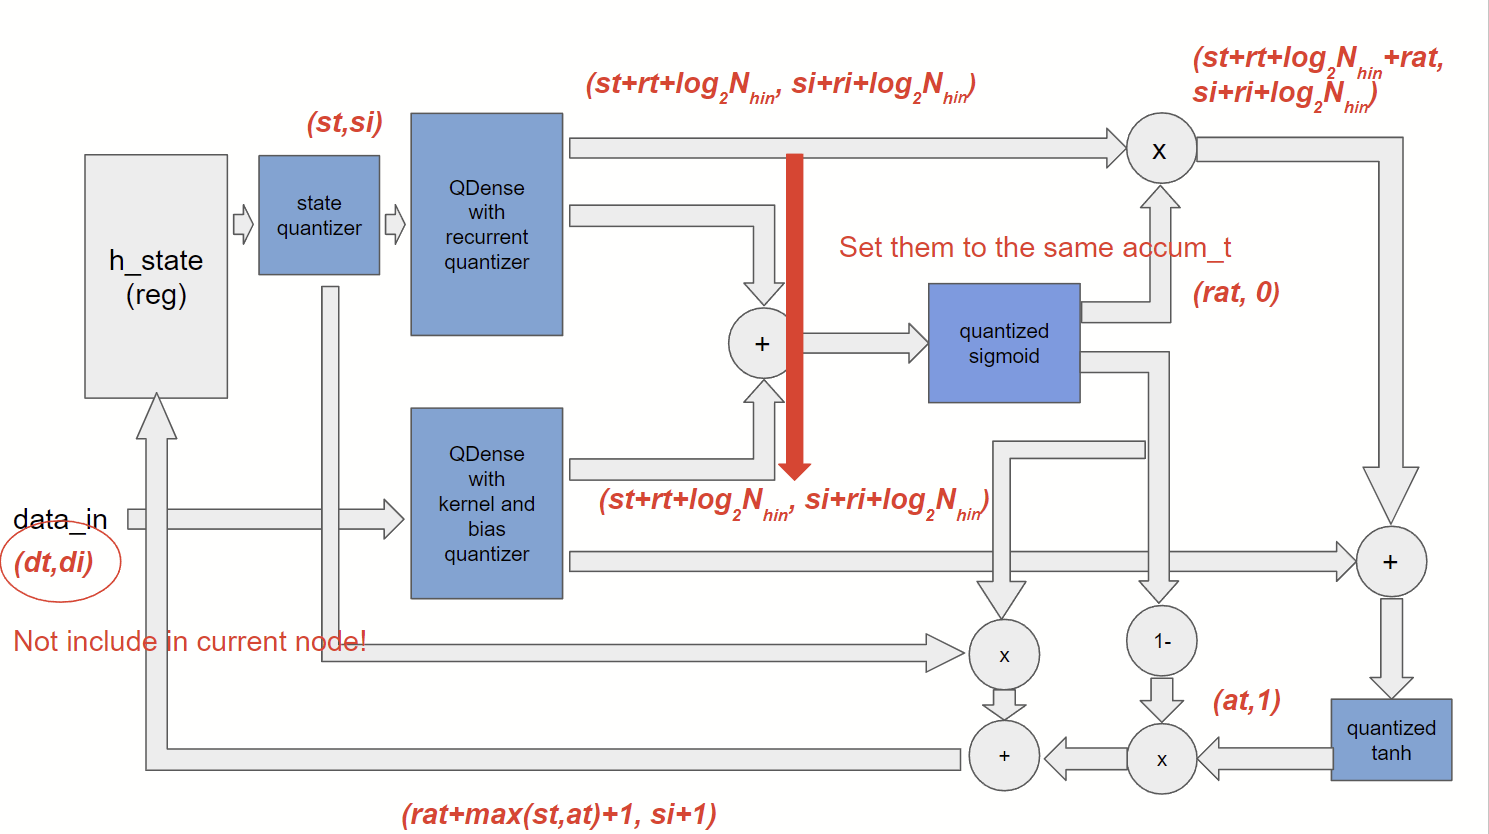

## the ACCUM bits in QGRU is based on the state quantizer, so the previous act_quan precision should be less than it
## here set the state quantizer same as the act_quan

# input for decoder GRU
# Assuming inputs are zero and everything comes from the GRU

In [20]:
decoder_dim = 64

In [21]:
def get_decoder_input(decoder_dim=64):
    inputs2decoder_train = tf.stack([tf.zeros_like(x_train)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_val = tf.stack([tf.zeros_like(x_val)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_train = np.array(inputs2decoder_train)
    inputs2decoder_val = np.array(inputs2decoder_val)
    print("inputs2decoder_train shape: ", inputs2decoder_train.shape)
    print("inputs2decoder_val shape: ", inputs2decoder_val.shape)
    return inputs2decoder_train, inputs2decoder_val

# Build models

In [22]:
inputs2decoder_train, inputs2decoder_val = get_decoder_input(decoder_dim=decoder_dim)

inputs2decoder_train shape:  (136, 73, 64)
inputs2decoder_val shape:  (17, 73, 64)


In [23]:
#pred_val_z, pred_val_logf = fmodel.predict([x_val, inputs2decoder_val])

In [24]:
def evaluate_NPLL(targets, pred_logrates):
    targets = tf.cast(targets, dtype=tf.float32)
    logrates = tf.cast(tf.math.log(0.01) + pred_logrates, tf.float32)  # Timestep
    npll = tf.nn.log_poisson_loss(targets=targets,log_input=logrates, compute_full_loss=True)
    results = tf.reduce_sum(npll, axis=[1, 2]) # sum up each batch seperately
    results = tf.reduce_mean(results) # batch mean

    print(results) # negative possion loglikelihood

In [25]:
#evaluate_NPLL(targets=x_val, pred_logrates=pred_val_logf)

In [26]:
#del fmodel

# loss: poisson_loglike_loss

In [27]:
from tensorflow.keras import backend as K

In [28]:
BATCH_SIZE=16

In [29]:
timestep = 0.01

def poisson_loglike_loss(y_true, y_pred):    
    # POISSON LOG-LIKELIHOOD
    # clip the y_pred first
    y_pred = tf.clip_by_value(y_pred, 
                                     clip_value_min=-threshold_poisson_log_firing_rate,
                                     clip_value_max=threshold_poisson_log_firing_rate
                             )
    targets = tf.cast(y_true, dtype=tf.float32)
    logrates = tf.cast(tf.math.log(timestep) + y_pred, tf.float32)  # Timestep
    npll = tf.nn.log_poisson_loss(
        targets=targets,
        log_input=logrates, compute_full_loss=True
    )
    #print(npll.shape)
    loss = tf.reduce_sum(npll, axis=[1, 2]) # sum up each batch seperately
    loss = tf.reduce_mean(loss) # batch mean
    #loss = tf.reduce_sum()
    return loss

## Build a fp model and train

In [30]:
import tensorflow.keras.layers as tfl
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow import keras

In [31]:
class ExponentLogvar(tfl.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, inputs):
        inputs = tf.math.log(tf.exp(inputs) + var_min)
        return tf.exp(0.5 * inputs) 

In [32]:
class StandardRandomNormal(tfl.Layer):
    def __init__(self, seed=42, n_samples=4, **kwargs):
        super().__init__(**kwargs)
        self.seed = seed
        self.n_samples = n_samples

    def call(self, inputs):
        return K.random_normal(shape=tf.shape(inputs), mean=0.0, stddev=1.0, seed=self.seed)
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
            "seed": self.seed,
            "n_samples":  self.n_samples
            })
        return config                

## Build the encoder

In [33]:
def create_fpencoder(input_shape = (73,70),
                    encoder_dim=64,  
                   drop=dropout
                  ):
    
    # input layer
    inputLayer =  tfl.Input(shape=input_shape, name = 'encoder_input')        
    x = tfl.Dropout(drop, name = 'initial_dropout')(inputLayer)
    
    # encoder
    forward_layer = tfl.GRU(
            encoder_dim, 
            time_major=False,
            name="EncoderGRUForward",
            return_state=True,
            kernel_regularizer=layers_settings['encoder']['kernel_regularizer'],
            kernel_initializer=layers_settings['encoder']['kernel_initializer'],
            )
    
    backward_layer = tfl.GRU(
            encoder_dim, 
            time_major=False,
            name="EncoderGRUBackward",
            return_state=True, 
            go_backwards=True,
            kernel_regularizer=layers_settings['encoder']['kernel_regularizer'],
            kernel_initializer=layers_settings['encoder']['kernel_initializer'],
             )
                
    x = tfl.Bidirectional(
        forward_layer, 
        backward_layer=backward_layer,
        merge_mode='concat', 
        name = 'Encoder_BidirectionalGRU'
        )(x)[0]  
    
    x = tfl.Dropout(drop, name = 'postencoder_dropout')(x)

    # latent space    
    z_mean = tfl.Dense(decoder_dim, 
               kernel_regularizer=layers_settings['dense_mean']['kernel_regularizer'],
               kernel_initializer=layers_settings['dense_mean']['kernel_initializer'],
               name='dense_mean'
              )(x)
    z_log_var = tfl.Dense(decoder_dim, 
               kernel_regularizer=layers_settings['dense_logvar']['kernel_regularizer'],
               kernel_initializer=layers_settings['dense_logvar']['kernel_initializer'],
               name='dense_logvar'
              )(x)
    
    # sample 
    # z_mean + tf.exp(0.5 * z_log_var) * epsilon
    epsilon = StandardRandomNormal(seed=seed)(z_mean)
    z_var = ExponentLogvar()(z_log_var)
    z_var = tfl.Multiply()([z_var, epsilon])
    
    z = tfl.Add()([z_mean, z_var])
    
    encoder = Model(inputs = inputLayer, outputs = [z_mean, z_log_var, z], name="encoder")
    
    return encoder
    

In [34]:
encoder = create_fpencoder()

In [35]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['encoder_input[0][0]']          
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                            

In [36]:
from tensorflow.keras.utils import plot_model


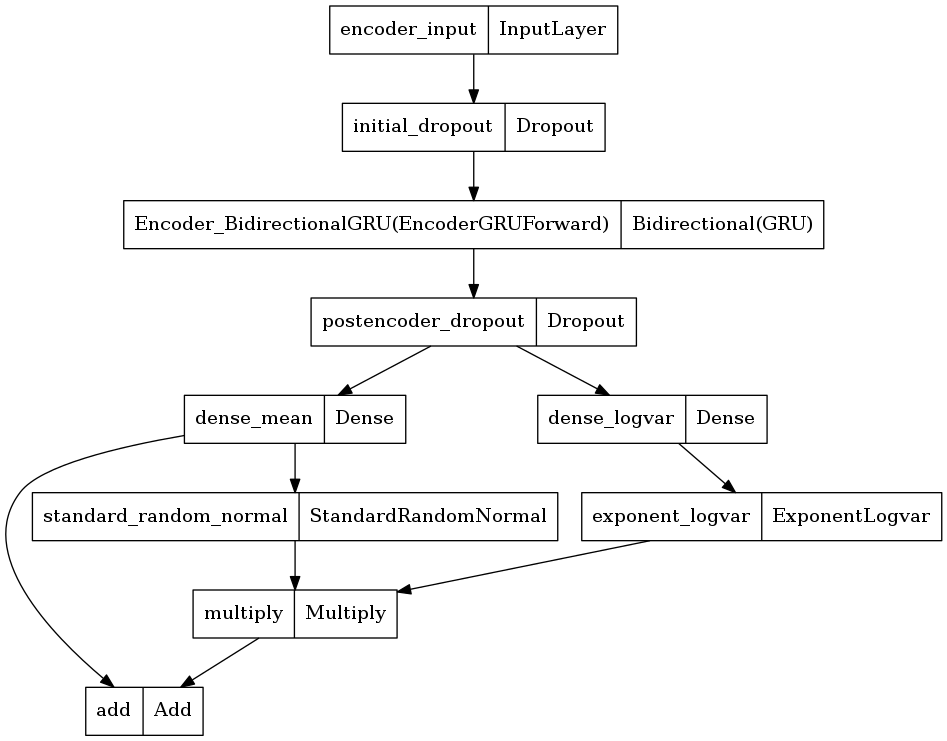

In [37]:
plot_model(encoder)

# Build the decoder

## since the latent vector will become the initial state of the decoder GRU, 
## decoder_dim = latent dimension

In [38]:
decoder_args

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x7f51d0a98af0>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f51d0a98cd0>,
 'recurrent_regularizer': <keras.regularizers.L2 at 0x7f51d0a98d30>,
 'original_cell': False}

In [39]:
del  decoder_args['original_cell']

In [40]:
def create_fpdecoder(input_shape = (73,70),
                     decoder_dim=decoder_dim,  
                     factors = 4,
                     drop=dropout
                     ):
    
    # decoder
    input_decoder_shape = (input_shape[0], decoder_dim) #( 73 timesteps, 64 decoder_dim)
    input_decoder = tfl.Input(shape=input_decoder_shape, name = 'decoder_input')
    
    # sampled latent 
    latent_inputs = tfl.Input(shape=(decoder_dim,), name = 'latent_input')
        
    x = tfl.GRU(
                decoder_dim,                
                return_sequences=True,
                time_major=False,
                name='DecoderGRU',
                **decoder_args
                )(input_decoder, initial_state = latent_inputs)
    x = tfl.Dropout(drop, name = 'postdecoder_dropout')(x)
    
    # DIMENSIONALITY REDUCTION
    z = tfl.Dense(
            factors, 
            use_bias=False, 
            kernel_regularizer=layers_settings['dense']['kernel_regularizer'],
            kernel_initializer=layers_settings['dense']['kernel_initializer'],
            name="dense"
            )(x)
    
    # NEURAL
    neural_dim = input_shape[-1] #70
    
    z = tfl.Dense(
            neural_dim, 
            use_bias=True, 
            kernel_regularizer=layers_settings['nerual_dense']['kernel_regularizer'],
            kernel_initializer=layers_settings['nerual_dense']['kernel_initializer'],
            name='nerual_dense')(z)
    
    
    decoder = Model(inputs = [latent_inputs, input_decoder], outputs =z , name="decoder")
    
    return decoder
    

In [41]:
decoder = create_fpdecoder()

In [42]:
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, 73, 64)]     0           []                               
                                                                                                  
 latent_input (InputLayer)      [(None, 64)]         0           []                               
                                                                                                  
 DecoderGRU (GRU)               (None, 73, 64)       24960       ['decoder_input[0][0]',          
                                                                  'latent_input[0][0]']           
                                                                                                  
 postdecoder_dropout (Dropout)  (None, 73, 64)       0           ['DecoderGRU[0][0]']       

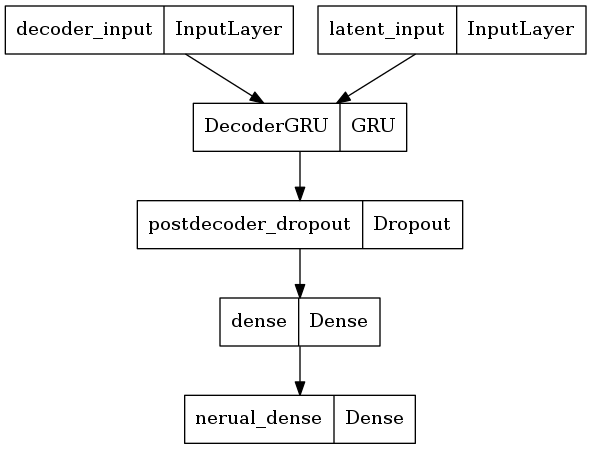

In [43]:
plot_model(decoder)

In [44]:
import tensorflow_probability as tfp


def gaussian_kldiv_loss(mean_r, logvar_r):
    # KL DIVERGENCE
    dist_prior = tfp.distributions.Normal(0., tf.sqrt(
        prior_variance), name='RelevantPriorNormal')  # PriorVariance
    dist_posterior = tfp.distributions.Normal(
        mean_r, tf.exp(0.5 * logvar_r), name='RelevantPosteriorNormal')
    return tf.reduce_sum(tfp.distributions.kl_divergence(
        dist_prior, dist_posterior, allow_nan_stats=False, name=None
    ))

# combined 

In [45]:
class LFADS(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        # loss track
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.poisson_loglike_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.reg_loss_tracker = keras.metrics.Sum(name="reg_loss") # not mean
        
        # loss weight track
        self.tracker_loss_w_loglike = keras.metrics.Mean(
            name="loss_w_loglike")
        self.tracker_loss_w_kldiv = keras.metrics.Mean(name="loss_w_kldiv")
        self.tracker_loss_w_reg = keras.metrics.Mean(name="loss_w_reg")
        self.tracker_lr = keras.metrics.Mean(name="lr")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.poisson_loglike_loss_tracker,
            self.kl_loss_tracker,
        ]
    def compile(self, optimizer, loss_weights, *args, **kwargs):
        super(LFADS, self).compile(
            optimizer=optimizer
        )
        self.loss_weights = loss_weights

    def train_step(self, data):
        x, y, sample_weight = tf.keras.utils.unpack_x_y_sample_weight(data)
        #print(sample_weight)
        
        #x, y = data
        x_in, decoder_in = x
        #print(x[0])
        #print(x[1])
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x_in)
            reconstruction = self.decoder((z, decoder_in))
            
            pll_loss = poisson_loglike_loss(y, reconstruction)
            #kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            #kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            kl_loss = gaussian_kldiv_loss(z_mean, z_log_var)
            reg_loss = tf.reduce_sum(self.losses)

            
            total_loss = self.loss_weights[0] * pll_loss + self.loss_weights[1] * kl_loss + self.loss_weights[2] * reg_loss
            unclipped_grads = tape.gradient(total_loss, self.trainable_variables)
            
        value_clipped_grads = [tf.clip_by_value(
            x, -1e16, 1e16) if x is not None else x for x in unclipped_grads]
        grads, grad_global_norm = tf.clip_by_global_norm(
            value_clipped_grads, 200)
        # Run backwards pass.

        self.optimizer.apply_gradients(
            (grad, var)
            for (grad, var) in zip(grads, self.trainable_variables)
            if grad is not None
        )
        
        #grads = tape.gradient(total_loss, self.trainable_weights)
        #self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # metrics
        self.total_loss_tracker.update_state(total_loss)
        self.poisson_loglike_loss_tracker.update_state(pll_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reg_loss_tracker.update_state(reg_loss)
        
        self.tracker_loss_w_loglike.update_state(self.loss_weights[0])
        self.tracker_loss_w_kldiv.update_state(self.loss_weights[1])
        self.tracker_loss_w_reg.update_state(self.loss_weights[2])
        self.tracker_lr.update_state(
            self.optimizer._decayed_lr('float32').numpy())
        
        return {
            "loss": self.total_loss_tracker.result(),
            "pll_loss": self.poisson_loglike_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reg_loss": self.reg_loss_tracker.result(),
            'weights/loglike': self.tracker_loss_w_loglike.result(),
            'weights/kldiv': self.tracker_loss_w_kldiv.result(),
            'weights/reg': self.tracker_loss_w_reg.result(),
            'learning_rate': self.tracker_lr.result()
        }
            
      
    def test_step(self, data):
        x, y, sample_weight = tf.keras.utils.unpack_x_y_sample_weight(data)
        #x, y = data
        x_in, decoder_in = x

        z_mean, z_log_var, z = self.encoder(x_in)
        reconstruction = self.decoder((z, decoder_in))

        pll_loss = poisson_loglike_loss(y, reconstruction)
        kl_loss = gaussian_kldiv_loss(z_mean, z_log_var)
        #kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        #kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            
        total_loss = self.loss_weights[0] * pll_loss + self.loss_weights[1] * kl_loss
        return {
          "loss": total_loss,
          "pll_loss": pll_loss,
          "kl_loss": kl_loss,
        }
    def call(self, data):
        x_in, decoder_in = data
        
        z_mean, z_log_var, z = self.encoder(x_in)
        reconstruction = self.decoder((z, decoder_in))
        
        # Add KL divergence regularization loss.
        #kl_loss = -0.5 * tf.reduce_mean(
        #    z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        #)
        kl_loss = gaussian_kldiv_loss(z_mean, z_log_var)
        self.add_loss(kl_loss)
        return reconstruction
        

In [46]:
model = LFADS(encoder, decoder)


# train
## callbacks

In [47]:
from tndm.utils import AdaptiveWeights

In [48]:
adaptive_weights=AdaptiveWeights(
        initial=[initial_neural_weight, initial_behaviour_weight, .0, .0, lambda_q, .0], #changed
        update_start=[0, 0, 0, 1000, 1000, 0],
        update_rate=[0., 0., update_rate, update_rate, 0.0, update_rate],
        min_weight=[initial_neural_weight, initial_behaviour_weight, 0.0, 0.0, lambda_q, 0.0],#changed
        max_weight=[initial_neural_weight, initial_behaviour_weight, 1.0, 1.0, lambda_q, 1.0],#changed
    )

In [49]:
adaptive_lr=dict(factor=0.95, patience=10, min_lr=1e-5)

In [50]:
adaptive_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_pll_loss', **adaptive_lr)

In [51]:
csv_logger = tf.keras.callbacks.CSVLogger("guassian_fp_log.csv", separator=",", append=False)
model_check = tf.keras.callbacks.ModelCheckpoint(
    "guassian_lfadfp.h5",
    monitor = "val_pll_loss",
    save_best_only = True,
    save_weights_only= True
)
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_pll_loss",
    min_delta=0,
    patience=100,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

#lfadfp_callbacks=[csv_logger, model_check, early]
lfadfp_callbacks=[csv_logger, 
                  model_check, 
                  #early, 
                  adaptive_weights, 
                  adaptive_lr_callback
                 ]

In [52]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08,
#global_clipnorm=200 , clipvalue=1e16
)


In [53]:
model.compile(
    optimizer = optimizer,
    loss_weights=adaptive_weights.w
)

In [54]:
fpmodel_history=model.fit([x_train, inputs2decoder_train], x_train, batch_size = BATCH_SIZE, 
                          epochs=1000, 
          callbacks = lfadfp_callbacks,
          validation_data=([x_val, inputs2decoder_val], x_val)
         )

Epoch 1/1000


/home/docker/anaconda3/envs/NNGEN/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/nvidia/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


9/9 [==============================] - 2s 118ms/step - loss: 3103.4309 - pll_loss: 3096.2976 - kl_loss: 37.4143 - reg_loss: 36.8642 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0011 - learning_rate: 0.0100 - val_loss: 2751.2566 - val_pll_loss: 2751.0010 - val_kl_loss: 1.2785 - lr: 0.0100
Epoch 2/1000
9/9 [==============================] - 1s 128ms/step - loss: 2600.0487 - pll_loss: 2595.7062 - kl_loss: 22.5152 - reg_loss: 104.9082 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0034 - learning_rate: 0.0100 - val_loss: 2455.7834 - val_pll_loss: 2455.4395 - val_kl_loss: 1.7204 - lr: 0.0100
Epoch 3/1000
9/9 [==============================] - 1s 122ms/step - loss: 2313.3430 - pll_loss: 2308.8699 - kl_loss: 19.4219 - reg_loss: 181.4935 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0056 - learning_rate: 0.0100 - val_loss: 2203.3640 - val_pll_loss: 2203.0120 - val_kl_loss: 1.7598 - lr: 0.0100
Epoch 4/1000
9/9 [=====================

9/9 [==============================] - 1s 82ms/step - loss: 1821.0749 - pll_loss: 1819.5692 - kl_loss: 1.2506 - reg_loss: 2725.7148 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0573 - learning_rate: 0.0100 - val_loss: 1814.6110 - val_pll_loss: 1814.5973 - val_kl_loss: 0.0681 - lr: 0.0100
Epoch 27/1000
9/9 [==============================] - 1s 76ms/step - loss: 1814.3245 - pll_loss: 1812.7678 - kl_loss: 1.5966 - reg_loss: 2821.1854 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0596 - learning_rate: 0.0100 - val_loss: 1813.4930 - val_pll_loss: 1813.4700 - val_kl_loss: 0.1151 - lr: 0.0095
Epoch 28/1000
9/9 [==============================] - 1s 76ms/step - loss: 1822.3016 - pll_loss: 1820.6408 - kl_loss: 1.9817 - reg_loss: 2913.6030 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0618 - learning_rate: 0.0100 - val_loss: 1809.4971 - val_pll_loss: 1809.4805 - val_kl_loss: 0.0833 - lr: 0.0095
Epoch 29/1000
9/9 [====================

9/9 [==============================] - 1s 86ms/step - loss: 1809.2249 - pll_loss: 1807.6284 - kl_loss: 1.8190 - reg_loss: 4419.3398 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.1136 - learning_rate: 0.0096 - val_loss: 1813.8008 - val_pll_loss: 1813.7896 - val_kl_loss: 0.0559 - lr: 0.0090
Epoch 52/1000
9/9 [==============================] - 1s 86ms/step - loss: 1823.8316 - pll_loss: 1822.3189 - kl_loss: 1.3675 - reg_loss: 4467.0221 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.1159 - learning_rate: 0.0096 - val_loss: 1812.3517 - val_pll_loss: 1812.3381 - val_kl_loss: 0.0678 - lr: 0.0086
Epoch 53/1000
9/9 [==============================] - 1s 78ms/step - loss: 1812.2963 - pll_loss: 1810.7197 - kl_loss: 1.6936 - reg_loss: 4513.3399 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.1181 - learning_rate: 0.0096 - val_loss: 1813.2988 - val_pll_loss: 1813.2852 - val_kl_loss: 0.0685 - lr: 0.0086
Epoch 54/1000
9/9 [====================

9/9 [==============================] - 1s 106ms/step - loss: 1800.1136 - pll_loss: 1798.2435 - kl_loss: 3.5142 - reg_loss: 5400.8356 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.1698 - learning_rate: 0.0092 - val_loss: 1801.5306 - val_pll_loss: 1801.4590 - val_kl_loss: 0.3584 - lr: 0.0081
Epoch 77/1000
9/9 [==============================] - 1s 64ms/step - loss: 1806.4966 - pll_loss: 1804.1987 - kl_loss: 4.3197 - reg_loss: 5435.6391 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.1721 - learning_rate: 0.0092 - val_loss: 1815.8235 - val_pll_loss: 1815.7888 - val_kl_loss: 0.1733 - lr: 0.0081
Epoch 78/1000
9/9 [==============================] - 1s 74ms/step - loss: 1801.5239 - pll_loss: 1799.3219 - kl_loss: 4.1085 - reg_loss: 5470.2554 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.1744 - learning_rate: 0.0092 - val_loss: 1811.2764 - val_pll_loss: 1811.2423 - val_kl_loss: 0.1703 - lr: 0.0081
Epoch 79/1000
9/9 [===================

9/9 [==============================] - 1s 58ms/step - loss: 1798.6501 - pll_loss: 1796.5496 - kl_loss: 3.4937 - reg_loss: 6194.2436 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.2261 - learning_rate: 0.0089 - val_loss: 1811.5406 - val_pll_loss: 1811.5148 - val_kl_loss: 0.1296 - lr: 0.0074
Epoch 102/1000
9/9 [==============================] - 1s 78ms/step - loss: 1801.9655 - pll_loss: 1799.9644 - kl_loss: 3.2526 - reg_loss: 6221.1501 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.2284 - learning_rate: 0.0088 - val_loss: 1804.7249 - val_pll_loss: 1804.6702 - val_kl_loss: 0.2733 - lr: 0.0074
Epoch 103/1000
9/9 [==============================] - 1s 58ms/step - loss: 1803.9167 - pll_loss: 1801.9382 - kl_loss: 3.0794 - reg_loss: 6247.4839 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.2306 - learning_rate: 0.0088 - val_loss: 1814.3680 - val_pll_loss: 1814.2957 - val_kl_loss: 0.3621 - lr: 0.0074
Epoch 104/1000
9/9 [=================

9/9 [==============================] - 1s 68ms/step - loss: 1802.6147 - pll_loss: 1800.5210 - kl_loss: 3.5647 - reg_loss: 6770.2427 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.2824 - learning_rate: 0.0085 - val_loss: 1810.9045 - val_pll_loss: 1810.8528 - val_kl_loss: 0.2585 - lr: 0.0066
Epoch 127/1000
9/9 [==============================] - 1s 71ms/step - loss: 1810.8647 - pll_loss: 1809.0896 - kl_loss: 2.4122 - reg_loss: 6790.8347 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.2846 - learning_rate: 0.0085 - val_loss: 1806.3516 - val_pll_loss: 1806.2719 - val_kl_loss: 0.3986 - lr: 0.0063
Epoch 128/1000
9/9 [==============================] - 1s 72ms/step - loss: 1814.5303 - pll_loss: 1812.4142 - kl_loss: 3.8822 - reg_loss: 6811.1555 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.2868 - learning_rate: 0.0084 - val_loss: 1805.4705 - val_pll_loss: 1805.3961 - val_kl_loss: 0.3715 - lr: 0.0063
Epoch 129/1000
9/9 [=================

KeyboardInterrupt: 

In [ ]:
plt.plot(fpmodel_history.history['loss'])
plt.plot(fpmodel_history.history['val_loss'])
plt.title('fp model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("fp model loss")
plt.show()

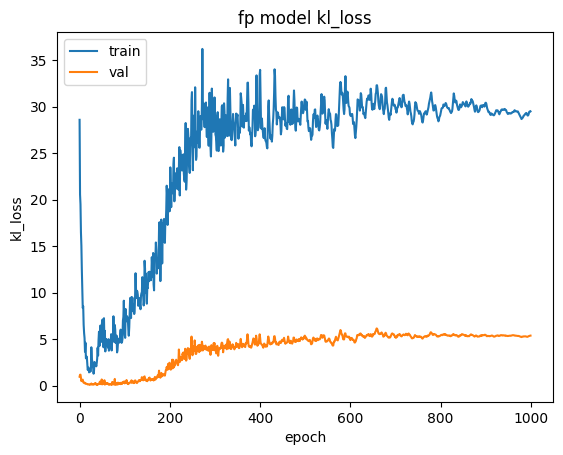

In [65]:
plt.plot(fpmodel_history.history['kl_loss'])
plt.plot(fpmodel_history.history['val_kl_loss'])
plt.title('fp model kl_loss')
plt.ylabel('kl_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig("fp model loss")
plt.show()

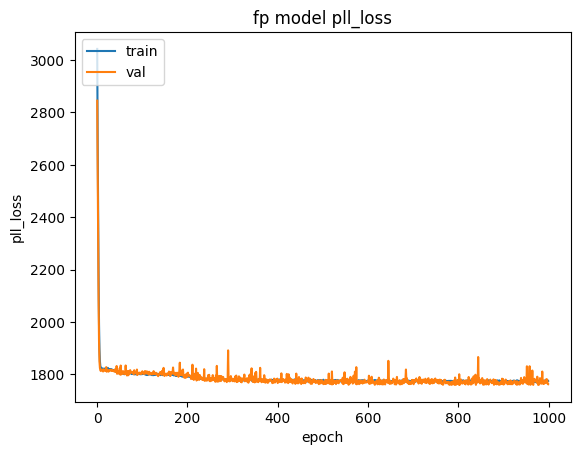

In [66]:
plt.plot(fpmodel_history.history['pll_loss'])
plt.plot(fpmodel_history.history['val_pll_loss'])
plt.title('fp model pll_loss')
plt.ylabel('pll_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("fp model pll_")
plt.show()

In [67]:
pred_val_logf = model.predict([x_val, inputs2decoder_val])

In [68]:
evaluate_NPLL(targets=x_val, pred_logrates=pred_val_logf)

tf.Tensor(1781.6503, shape=(), dtype=float32)


# reload the best model

In [69]:
model.load_weights("guassian_lfadfp.h5")

In [70]:
pred_val_logf = model.predict([x_val, inputs2decoder_val])
evaluate_NPLL(targets=x_val, pred_logrates=pred_val_logf)

tf.Tensor(1781.7037, shape=(), dtype=float32)


In [71]:
model.encoder.save("lfad_guassian_encoder.h5")

[13:54:37.640] WARNING [tensorflow.try_build_compiled_arguments:328] Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


In [72]:
model.decoder.save("lfad_guassian_decoder.h5")

[13:54:38.053] WARNING [tensorflow.try_build_compiled_arguments:328] Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


# Combine Encoder and Decoder

In [73]:
encoder_sample_in = encoder.inputs
encoder_sample_out = encoder.outputs[-1]

In [74]:
for l in model.decoder.layers:
    print(l)

## get decoder layers

In [75]:
decoder_latent_in, decocder_in = decoder.inputs
decoder_DecoderGRU = model.decoder.get_layer("DecoderGRU")
decoder_postdecoder_dropout = model.decoder.get_layer("postdecoder_dropout")
decoder_dense = model.decoder.get_layer("dense")                                                                                                      
decoder_nerual_dense = model.decoder.get_layer("nerual_dense")                                                                                                  

In [76]:
decoder_DecoderGRU_out = decoder_DecoderGRU(decocder_in, initial_state = encoder_sample_out)
decoder_postdecoder_dropout_out = decoder_postdecoder_dropout(decoder_DecoderGRU_out)
decoder_dense_out = decoder_dense(decoder_postdecoder_dropout_out)
decoder_nerual_dense_out = decoder_nerual_dense(decoder_dense_out)

In [77]:
lfads_full = Model(inputs = [encoder_sample_in, decocder_in], outputs = decoder_nerual_dense_out)

In [78]:
lfads_full.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['encoder_input[0][0]']          
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                              

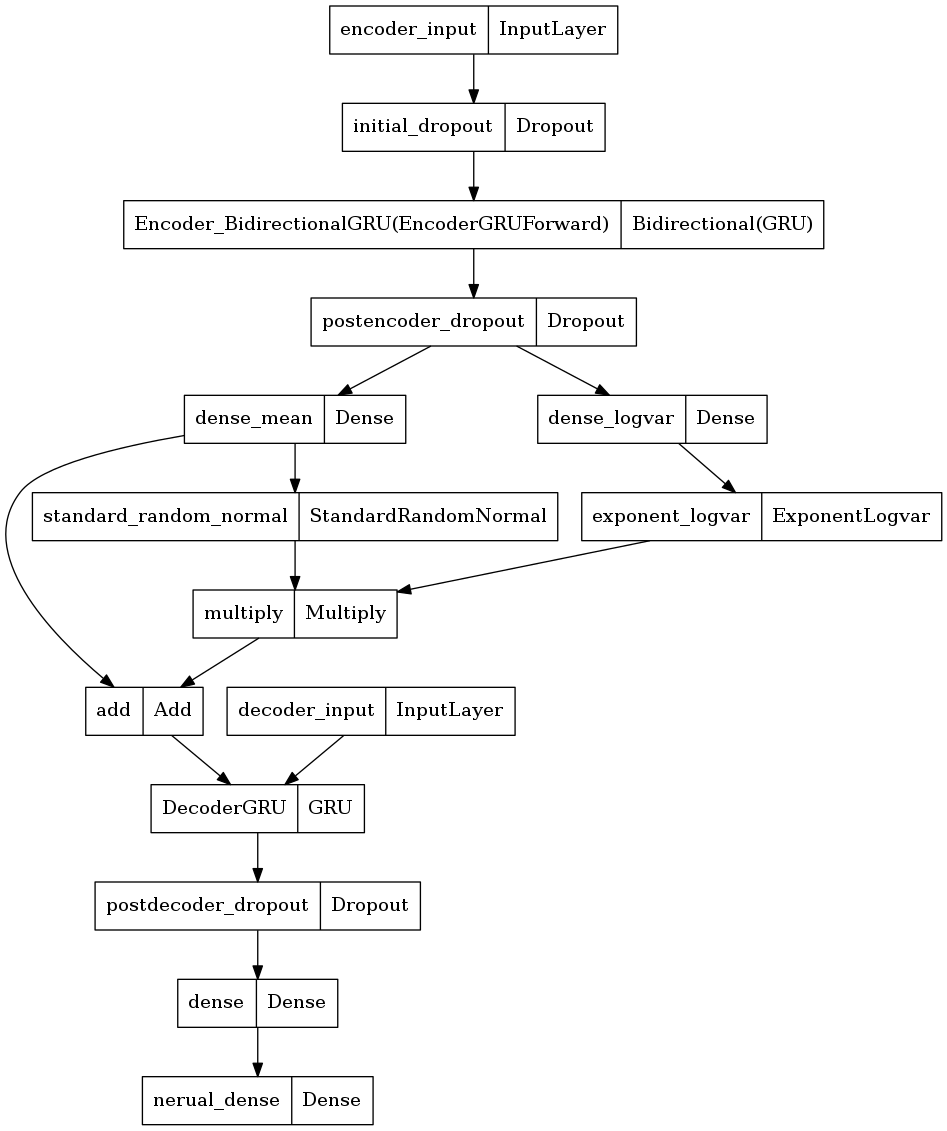

In [79]:
plot_model(lfads_full)

In [80]:
pred_val_logf = lfads_full.predict([x_val, inputs2decoder_val])
evaluate_NPLL(targets=x_val, pred_logrates=pred_val_logf)

tf.Tensor(1781.053, shape=(), dtype=float32)


In [81]:
lfads_full.save("lfads_guassian_full_fpmodel.h5")

[13:54:43.929] WARNING [tensorflow.try_build_compiled_arguments:328] Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


# test r2

In [82]:
from tensorflow.keras.models import load_model

In [83]:
custom_objects={
                "ExponentLogvar": ExponentLogvar,
                "StandardRandomNormal": StandardRandomNormal
               }

In [84]:
fmodel = load_model("lfads_guassian_full_fpmodel.h5", compile = False, custom_objects=custom_objects)

In [85]:
keras.__version__

'2.8.0'

In [86]:
fmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['encoder_input[0][0]']          
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                              

In [87]:
factors_layer = fmodel.get_layer("dense")

In [88]:
z_model = Model(fmodel.inputs,  factors_layer.output)
z_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['encoder_input[0][0]']          
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                            

In [89]:
z =  z_model.predict([x_train, inputs2decoder_train])

In [92]:
from sklearn.linear_model import Ridge

In [93]:
factors_reconstruct = np.arange(4)

X = np.transpose(z[:,:,factors_reconstruct], (0,2,1)).reshape((z.shape[0], -1))
y = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))

Xt = X
yt = y

reg = Ridge(normalize=True, fit_intercept=True).fit(X, y)
print(reg.score(Xt, yt))
beh_fit = reg.predict(Xt)
b = np.zeros_like(behavioural_data)
b[:,:,0] = beh_fit[:,:behavioural_data.shape[1]]
b[:,:,1] = beh_fit[:,behavioural_data.shape[1]:]

0.42713210532819956


/home/docker/anaconda3/envs/NNGEN/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
